In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:86% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.output {font-size:15pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:15px;}
</style>
"""))

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

- Red Wine 등급 예측
1. 데이터 셋 확보<br>
    csv -> 결측치 처리 -> 독립변수와 타겟변수 분리 -> 독립변수 스케일 조정<br>
    -> 타겟 변수 원핫인코딩 -> 훈련셋과 테스트셋 분리(train_test_split 이용 층화추출)<br>
2. 모델 구성(입력11, 출력 6| 출력9) layer층 4
3. 모델 학습 과정 설정
4. 모델학습(callbacks이용)
5. 모델 평가(그래프, 평가, 교차표)
6. 모델 저장 & 사용

# 1. 데이터 확보 & 전처리

In [37]:
# 데이터 읽어오기
# fixed acidity : 고정 산도
# volatile acidity : 휘발성 산도
# citric acid : 시트르산
# residual sugar : 잔류 당분
# chlorides : 염화물
# free sulfur dioxide : 자유 이산화황
# total sulfur dioxide : 총 이산화황
# density : 밀도
# pH
# sulphates : 황산염
# alcohol
# quality : 0 ~ 10(높을 수록 좋은 품질)
redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [38]:
redwine.info()
redwine.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


(1599, 12)

Epoch 1/100
23/32 [====================>.........] - ETA: 0s - loss: 1.5385 - accuracy: 0.4253 
Epoch 1: val_loss improved from inf to 1.13652, saving model to best_model.h5
32/32 [==============================] - 1s 9ms/step - loss: 1.4496 - accuracy: 0.4585 - val_loss: 1.1365 - val_accuracy: 0.5547
Epoch 2/100
22/32 [===================>..........] - ETA: 0s - loss: 1.1872 - accuracy: 0.5142
Epoch 2: val_loss improved from 1.13652 to 1.05254, saving model to best_model.h5
32/32 [==============================] - 0s 5ms/step - loss: 1.1377 - accuracy: 0.5337 - val_loss: 1.0525 - val_accuracy: 0.5703
Epoch 3/100
22/32 [===================>..........] - ETA: 0s - loss: 1.0320 - accuracy: 0.5966
Epoch 3: val_loss improved from 1.05254 to 1.01745, saving model to best_model.h5
32/32 [==============================] - 0s 5ms/step - loss: 1.0511 - accuracy: 0.5748 - val_loss: 1.0174 - val_accuracy: 0.5859
Epoch 4/100
23/32 [====================>.........] - ETA: 0s - loss: 0.9636 - accurac

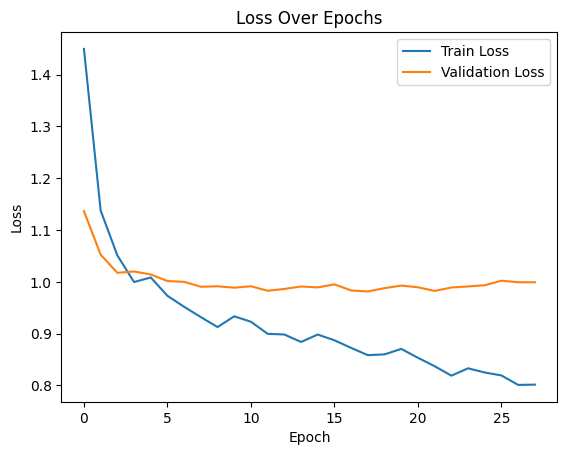

10/10 [==============================] - 0s 1ms/step


In [42]:
# 1. 데이터 전처리
redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine.dropna(inplace=True)

X = redwine.drop('quality', axis=1).values
y = redwine['quality'].values

# 정수 인코딩
le = LabelEncoder()
y_encoded_int = le.fit_transform(y)

# 원핫 인코딩
y_encoded = to_categorical(y_encoded_int)
num_classes = y_encoded.shape[1]

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 훈련/테스트셋 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                    y_encoded,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y_encoded_int)

# 2. 모델 구성
model = Sequential()
model.add(Input(shape=(X.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# 3. 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 4. 콜백 및 학습
es = EarlyStopping(monitor='val_loss',
                   patience=10,
                   verbose=1,
                   restore_best_weights=True)
mc = ModelCheckpoint('best_model.h5',
                     monitor='val_loss',
                     save_best_only=True,
                     verbose=1)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                            test_size=0.2,
                                            stratify=np.argmax(y_train, axis=1),
                                            random_state=42)

history = model.fit(X_tr, y_tr,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[es, mc], verbose=1)

# 5. 평가
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {acc:.4f}')

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# 6. 교차표
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# 7. 모델 저장
model.save('final_redwine_model.h5')


In [43]:
model.evaluate(X_val, y_val)

8/8 [==============================] - 0s 2ms/step - loss: 0.9815 - accuracy: 0.6055


[0.981457531452179, 0.60546875]